In [1]:
print(__doc__)

import os
import time
import json
import pickle
import math

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.special import expit
from scipy import stats
from pylab import rcParams
import mplcursors

from sklearn.utils import check_random_state
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn import linear_model
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


# pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.1f}".format

max_queried = 500
trainset_size = 1302

Automatically created module for IPython interactive environment


In [2]:
def data_prep():
    data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/ML-for-COVID-19-dataset/main/all_training.csv", sep=',')
    # Column selection
    df = data.iloc[:,np.r_[3:34]].copy()
    # define row and column index
    col = df.columns
    row = [i for i in range(df.shape[0])]
    # define imputer
    imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
    # fit on the dataset
    imputer.fit(df)
    # transform the dataset
    df_imputed = imputer.transform(df)
    # convert back to pandas dataframe and rename back to df_normalized
    df = pd.DataFrame(data=df_imputed, index=row, columns=col)
    X = df
    y = data.target    
    # Recursive feature elimination
    rdmreg = RandomForestClassifier(n_estimators=100)
    # Define the method
    rfe = RFE(estimator=rdmreg, n_features_to_select=10)
    # Fit the model
    rfe = rfe.fit(X, y.values.ravel())
    print(rfe.support_)
    # Drop columns that failed RFE test
    col = df.columns[rfe.support_]
    X = X[col]
    X = X.to_numpy()
    print ('df:', X.shape, y.shape)
    return (X, y)


# def split(train_size):
#     X_train_full = X[:train_size]
#     y_train_full = y[:train_size]
#     X_test = X[train_size:]
#     y_test = y[train_size:]   
#     return (X_train_full, y_train_full, X_test, y_test)


In [3]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(
            C=1, 
            kernel='linear', 
            probability=True,
            class_weight=c_weight
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class LogModel(BaseModel):

    model_type = 'Logistic Regression' 
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training logistic regression...')
        # train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            # C=50. / train_samples,
            penalty='l1',
            solver='liblinear',
            tol=0.1,
            class_weight=c_weight
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class RfModel(BaseModel):

    model_type = 'Random Forest'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(
            n_estimators=500, 
            class_weight=c_weight, 
            n_jobs=-1
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

class GDBCModel(BaseModel):

    model_type = 'Gradient Boost classifier'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training GDBC...')
        self.classifier = GradientBoostingClassifier(
            n_estimators=1200,
            max_depth=3,
            subsample=0.5,
            learning_rate=0.01,
            min_samples_leaf=1,
            random_state=3
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

class KnnModel(BaseModel):

    model_type = 'Nearest Neighbour classifier'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training KNN...')
        self.classifier = neighbors.KNeighborsClassifier(
            n_neighbors = 10,
            n_jobs = -1
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

In [4]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and use the probabilities to select the most uncertain samples
    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape)
        print ('Validation set:', X_val.shape)
        print ('Test set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)

    # we want accuracy only for the test set
    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Training run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate is %f " % (classif_rate))    
        print("Classification report for %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


In [5]:
class QueryFunction(object):

    def __init__(self):
        pass

    # def stream_select(self):
    #     pass

    def pool_select(self):
        pass


class RandomSelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        random_state = check_random_state(0)
        # probas_val.shape[0] is the size of validation set
        selection = np.random.choice(probas_val.shape[0], batch_size, replace=False)
        print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',batch_size)
        return selection


class EntropySelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:batch_size]
        return selection

class MinStdSelection(QueryFunction):

    # select the samples where the std is smallest. There is uncertainty regarding the relevant class
    # and then train on these "hard" to classify samples.
    @staticmethod
    def pool_select(probas_val, batch_size):
        std = np.std(probas_val * 100, axis=1) 
        selection = std.argsort()[:batch_size]
        selection = selection.astype('int64')
        print('std',std.shape,std)
        print('selection',selection, selection.shape, std[selection])
        return selection

class LeastConfidenceSelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        sort_prob = -np.sort(-probas_val, axis=1)
        values = sort_prob[:, 0]
        selection = np.argsort(values)[:batch_size]
        return selection
      
      
class MarginSamplingSelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        sort_prob = -np.sort(-probas_val, axis=1)
        values = sort_prob[:, 0] - sort_prob[:, 1]
        selection = np.argsort(values)[:batch_size]
        return selection


In [6]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = RobustScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

In [7]:
def get_random_samples(initial_samples, X_train_full,
                         y_train_full):

    random_state = check_random_state(0)

    permutation = np.random.choice(len(X_train_full),initial_samples,replace=False)
    
    # print ()
    # print(type(permutation))
    # print ('initial random chosen samples', permutation)

    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))

    # bin_count = np.bincount(y_train.astype('int64'))
    # unique = np.unique(y_train.astype('int64'))
    # print (
    #     'initial train set:',
    #     X_train.shape,
    #     y_train.shape,
    #     'unique(labels):',
    #     bin_count,
    #     unique,
    #     )
    return (permutation, X_train, y_train)

In [8]:
def log_loss(self, probs):

        loss = 0

        for i in range(len(probs)):
            for prob in probs[i]:
                loss -= (prob*np.log(prob))

        return loss/(len(probs)*1.)

In [9]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, step, model_object, selection_function):
        self.step = step
        self.model_object = model_object
        self.sample_selection_function = selection_function
        
# To-do: Move initiation selections as arguments
    def run(self, X_train_full, y_train_full, X_test, y_test, initial_queried, max_queried):

        # initialize process by applying base learner to labeled training data set to obtain Classifier
        (permutation, X_train, y_train) = \
            get_random_samples(initial_queried, X_train_full, y_train_full)
        self.queried = initial_queried
        # self.samplecount = [self.initiation_selections]

        # assign the val set the rest of the 'unlabelled' training data
        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        # print ('Val set:', X_val.shape, y_val.shape, permutation.shape)
        # print ()

        # normalize data
        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)
           
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # queried_num = [self.queried]

        while self.queried <= max_queried-self.step:

            active_iteration += 1
            self.queried += self.step
            # queried_num.append(self.queried)
            # get validation probabilities
            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            # print('Classifier class:', self.clf_model.model_object.classifier.classes_)
            # print('Probas_val:', probas_val)
            # pred_val = \
            #     self.clf_model.val_y_predicted
            # model_val = \
            #     self.clf_model
            # print ('val predicted:',
            #         self.clf_model.val_y_predicted.shape,
            #         self.clf_model.val_y_predicted)
            # display probability of binary value predictions of the validation set
            # print ('probas_val value', probas_val)
            # display which binary value has the highest probabilities of the validation set
            # print ('probabilities:', probas_val.shape, '\n',
            #        np.argmax(probas_val, axis=1))

            # select samples using a selection function
            uncertain_samples = self.sample_selection_function.pool_select(probas_val, self.step)

            # normalization needs to be inversed and recalculated based on the new train and test set.
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set
            # print ('trainset before adding uncertain samples', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            # print ('trainset after adding uncertain samples', X_train.shape, y_train.shape)
            # self.samplecount.append(X_train.shape[0])

            

            # bin_count = np.bincount(y_train.astype('int64'))
            # unique = np.unique(y_train.astype('int64'))
            # print (
            #     'updated train set:',
            #     X_train.shape,
            #     y_train.shape,
            #     'unique(labels):',
            #     bin_count,
            #     unique,
            #     )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            # print ('val set:', X_val.shape, y_val.shape)
            # print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            # self.queried += self.step

            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        # print('Queried numbers', queried_num)
        return self.clf_model.accuracies
        # print ('final active learning accuracies',
        #        self.clf_model.accuracies)

In [10]:
def pool_experiment(model,sampling_method,max_queried,initial_queried,step):
    (X, y) = data_prep()
    # (X_train_full, X_test,y_train_full,  y_test) = train_test_split(X, y, test_size=0.25)
    # print(type(X_train_full))

    kf = KFold(n_splits=4)

    for train_index, test_index in kf.split(X):
        X_train_full, X_test = X[train_index], X[test_index]
        y_train_full, y_test = y[train_index], y[test_index]
        
    act_alg = TheAlgorithm(step, model , sampling_method)
    accuracies = act_alg.run(X_train_full,y_train_full,X_test,y_test,initial_queried,max_queried)

    (permutation, X_train_selected, y_train_selected) = get_random_samples(initial_queried, X_train_full, y_train_full)
    original_accuracies=[]
    classifier_original = LogisticRegression(
            # C=50. / X_train_full.shape[0],
            penalty='l1',
            solver='liblinear',
            tol=0.1,
            class_weight='balanced')
    x_axis = []
    for i in range(initial_queried-1,max_queried,step):
        classifier_original.fit(X_train_selected[:i+1], y_train_selected[:i+1])
        y_pred_original = classifier_original.predict(X_test)
        original_accuracies.append(accuracy_score(y_test, y_pred_original)*100)
        x_axis.append(i+1)
    print("accuracies",accuracies)
    print("nonactive_accuracies",original_accuracies)
    print("x-axis:",x_axis)
    print("x-axis length:",len(x_axis))
    # x_axis = np.linspace(initial_queried,max_queried,num=(max_queried - initial_queried)//step +1,endpoint=True)
    plt.plot(x_axis, accuracies, 'r',label='active') 
    plt.plot(x_axis, original_accuracies, 'blue',label='non-active') 
    plt.legend()
    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy')
    plt.show()

In [11]:
# print ('train:', X_train_full.shape, y_train_full.shape)
# print ('test :', X_test.shape, y_test.shape)
# classes = len(np.unique(y))
# print ('unique classes', classes)

# def pickle_save(fname, data):
#   filehandler = open(fname,"wb")
#   pickle.dump(data,filehandler)
#   filehandler.close()
#   print('saved', fname, os.getcwd(), os.listdir())

# def pickle_load(fname):
#   print(os.getcwd(), os.listdir())
#   file = open(fname,'rb')
#   data = pickle.load(file)
#   file.close()
#   print(data)
#   return data
  
def batch_experiment(d, models, selection_functions, Ks, repeats, contfrom):

    (X, y) = data_prep()
    # (X_train_full, X_test,y_train_full,  y_test) = train_test_split(X, y, test_size=0.25)
    # print(type(X_train_full))

    from sklearn.model_selection import KFold
    kf = KFold(n_splits=4)

    for train_index, test_index in kf.split(X):
        X_train_full, X_test = X[train_index], X[test_index]
        y_train_full, y_test = y[train_index], y[test_index]

    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    # print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    # fname = '/Users/wenxuanhuang/Documents/Repo/ML-for-COVID-19-dataset/Results/Active-learning-experiment-' + str(count) + '.pkl'
                    # pickle_save(fname, d)
                    # if count % 5 == 0:
                    #     print(json.dumps(d, indent=2, sort_keys=True))
                    # print ()
                    # print ('---------------------------- FINISHED ---------------------------')
                    # print ()
    return d


# max_queried = 500 
# repeats = 1
# models = [LogModel] 
# # models = [SvmModel, RfModel, LogModel, GDBCModel, KnnModel] 
# selection_functions = [LeastConfidenceSelection] 
# # selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection, MinStdSelection, LeastConfidenceSelection] 
# Ks = [250,125,50,25,10] 
# d = {}
# stopped_at = -1 
# # print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
# # d = pickle_load('Active-learning-experiment-' + str(stopped_at) + '.pkl')  
# # print(json.dumps(d, indent=2, sort_keys=True))
# d = batch_experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
# # print (d)
# # results = json.loads(json.dumps(d, indent=2, sort_keys=True))
# # print(results)


In [12]:
# %matplotlib widget
# # %matplotlib inline
# def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
#     fig, ax = plt.subplots()
#     ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'upper-bound')
#     for model_object in models:
#       for selection_function in selection_functions:
#         for idx, k in enumerate(Ks):
#             x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
#             Sum = np.array(dic[model_object][selection_function][k][0])
#             for i in range(1, repeats):
#                 Sum = Sum + np.array(dic[model_object][selection_function][k][i])
#             mean = Sum / repeats
#             ax.plot(x, mean, label = model_object[0:3] + '-' + selection_function[0:3] + '-' + str(k))
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     ax.set_xlim([50,500])
#     ax.set_ylim([20,83])
#     ax.grid(True)
#     mplcursors.cursor()
#     plt.tight_layout()
#     plt.show()

# # models_str = ['SvmModel', 'RfModel', 'LogModel','GDBCModel','KnnModel']
# models_str = ['LogModel']
# # selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'EntropySelection', 'MinStdSelection','LeastConfidenceSelection']
# selection_functions_str = ['LeastConfidenceSelection']
# Ks_str = ['250','125','50','25','10'] 
# repeats = 10
# # random_forest_upper_bound = 89.
# # svm_upper_bound = 87.
# log_upper_bound = 87.
# # gdbc_upper_bound = 86.
# # knn_upper_bound = 86.
# total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

# print('So which is the better model? under the stopping condition and hyper parameters')
# # performance_plot(random_forest_upper_bound, d, ['RfModel'] , selection_functions_str    , Ks_str, 1)
# # performance_plot(svm_upper_bound, d, ['SvmModel'] , selection_functions_str    , Ks_str, 1)
# performance_plot(log_upper_bound, d, ['LogModel'] , selection_functions_str    , Ks_str, 1)
# # performance_plot(gdbc_upper_bound, d, ['GDBCModel'] , selection_functions_str    , Ks_str, 1)
# # performance_plot(log_upper_bound, d, ['KnnModel'] , selection_functions_str    , Ks_str, 1)

[ True False False False False False  True False  True  True False False
 False  True  True False False False False False False False False False
  True  True  True False False  True False]
df: (1736, 10) (1736,)
Train set: (26, 10)
Validation set: (1276, 10)
Test set: (434, 10)
training logistic regression...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (434,)
Training run in 0.002 s 

Accuracy rate is 76.728111 
Classification report for LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear',
                   tol=0.1):
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       321
           1       0.59      0.36      0.45       113

    accuracy                           0.77       434
   macro avg       0.69      0.64      0.65       434
weighted avg       0.75      0.77      0.75       434


Confusion matrix:
[[292  29]
 [ 72  41]]
--------------------------------
T

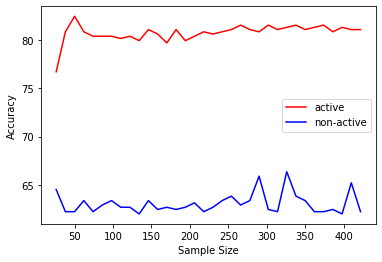

In [13]:

pool_experiment(LogModel,LeastConfidenceSelection,433,26,12)